In [1]:
import torch
import torch.nn as nn
import os
# Arrange GPU devices starting from 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 0"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'ch3_32_interval_3_240'
model = torch.load(os.path.join('models', model_name,f"{model_name}.pth"))
# model = _model.to(device)
# model = nn.DataParallel(model).to(device)
model.eval()

UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 32, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (

In [2]:
from utils import get_dataloader
from dataset import BratsDataset

test_dataloader = get_dataloader(dataset=BratsDataset, phase="test", img_depth=155, img_width=240, data_type=[
      "-t1n.nii.gz",
      "-t1c.nii.gz",
      # "-t2w.nii.gz",
      "-t2f.nii.gz"
    ], batch_size=1)


In [3]:
from utils import dice_coef_metric_per_classes, jaccard_coef_metric_per_classes
from skimage.transform import resize as sk_resize
import numpy as np
from tqdm import tqdm
def compute_scores_per_classes(model,          # nodel which is UNeT3D 
                               dataloader,     # tuple consisting of ( id , image tensor , mask tensor )
                               classes):       # classes : WT , TC , ET 
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            pred = torch.sigmoid(logits).detach().cpu().numpy()
            threshold = 0.5
            pred = (pred >= threshold).astype(int)
            # pred = np.array([sk_resize(_pred, (3, 155, 240, 240), preserve_range=True)
            #                 for _pred in pred])
            targets = targets.detach().cpu().numpy()
            
            # Now finding the overlap between the raw prediction i.e. logit & the mask i.e. target & finding the dice & iou scores 
            dice_scores = dice_coef_metric_per_classes(pred, targets)
            iou_scores = jaccard_coef_metric_per_classes(pred, targets)

            # storing both dice & iou scores in the list declared 
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes 

In [4]:
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, test_dataloader, ['WT', 'TC', 'ET']
    )

 29%|██▉       | 36/125 [00:17<00:40,  2.18it/s]

In [ ]:
import pandas as pd
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
# CONCAT BOTH THE COLUMNS ALONG AXIS 1 & SORT THE TWO 
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
61,0.692292,0.529393,0.867808,0.766485,0.876398,0.779990
89,0.947363,0.899991,0.789876,0.652723,0.702528,0.541459
39,0.936383,0.880377,0.975633,0.952425,0.919707,0.851350
40,0.754622,0.605938,0.938313,0.883794,0.828850,0.707723
75,0.941097,0.888747,0.963739,0.930016,0.942232,0.890774


In [ ]:
[i for i in val_metics_df.std()]

[0.08065588035987663,
 0.11830267465222562,
 0.18248818209817785,
 0.21040859112950025,
 0.25078774224775124,
 0.24613951320067703]

In [ ]:
val_metics_df.mean()

WT dice       0.901214
WT jaccard    0.828755
TC dice       0.838243
TC jaccard    0.753677
ET dice       0.769474
ET jaccard    0.674284
dtype: float64

In [ ]:
# val_metics_df.to_excel(f'inference_res/(re)method_2_{model_name}.xlsx')

/tmp/ipykernel_1842263/3144620632.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
/tmp/ipykernel_1842263/3144620632.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)


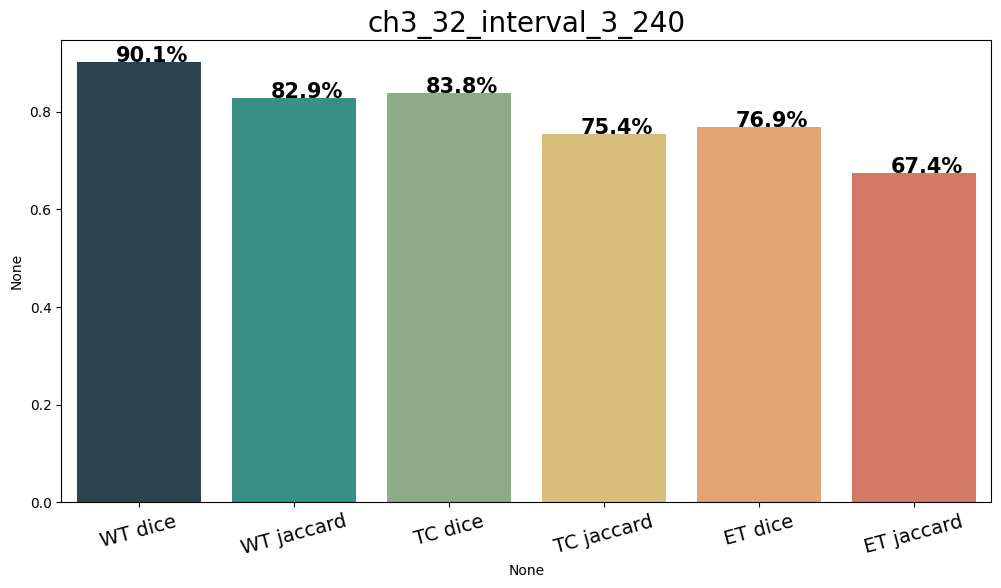

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#264653', '#2a9d8f', '#8ab17d', '#e9c46a', '#f4a261', '#e76f51']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)
ax.set_title(f"{model_name}", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

# fig.savefig(f"inference_res/(re){model_name}.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
# fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')